In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [12]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 5, 1, 0)
        self.fc1 = nn.Linear(92*16, 80)
        self.fc2 = nn.Linear(80, 40)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        mu = x[:, :20]
        log_var = x[:, 20:]
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(20, 1152)
        self.conv1 = nn.Conv1d(12, 12, 3, 1, 1)
        self.conv2 = nn.Conv1d(12, 1, 3, 1, 1)

    def forward(self, z):
        z = F.relu(self.fc(z))
        z = z.view(-1, 12, 96)
        z = F.relu(self.conv1(z))
        z = F.sigmoid(self.conv2(z))
        return z

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

In [13]:
def vae_loss(recon_x, x, mu, log_var):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [14]:
X = np.load('../data/X.npy')
X = torch.tensor(X, dtype=torch.float32)
y = np.load('../data/y.npy')
y = torch.tensor(y, dtype=torch.float32)
X = X[y == 0]
X /= X.std()

In [15]:
dataloader = DataLoader(X.unsqueeze(1), batch_size=64, shuffle=True)

model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

model.train()
num_epochs = 500
for epoch in range(num_epochs):
    for input_data in dataloader:
        optimizer.zero_grad()
        reconstructed, mu, log_var = model(input_data)
        loss = vae_loss(reconstructed, input_data, mu, log_var)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 2387.189453125
Epoch 1, Loss: 2880.71875
Epoch 2, Loss: 2283.308349609375
Epoch 3, Loss: 2425.95068359375
Epoch 4, Loss: 2719.54931640625
Epoch 5, Loss: 2813.84814453125
Epoch 6, Loss: 1968.2884521484375
Epoch 7, Loss: 2300.034912109375
Epoch 8, Loss: 2549.495849609375
Epoch 9, Loss: 3086.131103515625
Epoch 10, Loss: 3242.34130859375
Epoch 11, Loss: 3321.486328125
Epoch 12, Loss: 2000.1968994140625
Epoch 13, Loss: 2379.67822265625
Epoch 14, Loss: 2642.273681640625
Epoch 15, Loss: 2508.283447265625
Epoch 16, Loss: 3192.717529296875
Epoch 17, Loss: 2181.03955078125
Epoch 18, Loss: 2688.684814453125
Epoch 19, Loss: 2540.0859375
Epoch 20, Loss: 2759.0615234375
Epoch 21, Loss: 2372.949462890625
Epoch 22, Loss: 2694.796630859375
Epoch 23, Loss: 2837.777099609375
Epoch 24, Loss: 2435.0947265625
Epoch 25, Loss: 2613.19482421875
Epoch 26, Loss: 2142.85400390625
Epoch 27, Loss: 1891.545166015625
Epoch 28, Loss: 2540.525146484375
Epoch 29, Loss: 2289.9990234375
Epoch 30, Loss: 3210

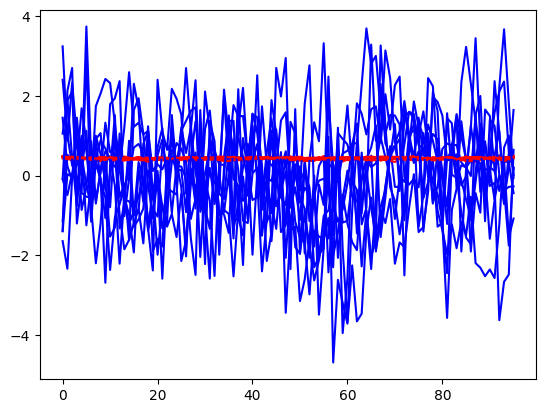

In [16]:
model.eval()
fake_data = model.decoder(torch.randn(10, 20))
for i in range(10):
    plt.plot(fake_data[i, 0].detach().numpy(), color='red')
    plt.plot(X[i].detach().numpy(), color='blue')
plt.show()